# Procesamiento de Información 2023
## Unidad 6 - Tarea
## Clasificación de información
### David Aarón Ramírez Olmeda

## Introducción

La categorización de documentos o clasificación de documentos consiste en ordenar un conjunto de documentos en categorías o clases previamente definidas.

Los documentos pueden ser desde textos cortos como tweets hasta documentos largos como libros. 

Tradicionalmente, la tarea de categorización es realizada por expertos del dominio de aplicación. Sin embargo, con las grandes cantidades de información que se generan diariamente es necesario usar métodos que clasifiquen automáticamente  la  información.

Desde el punto de vista del aprendizaje computacional, es prometedor aprender el esquema de categorización por medio de ejemplos de entrenamiento. Una vez aprendido el esquema de categorización (modelo de predicción), éste se puede usar para clasificar futuros documentos por categorizar.

Existen diversos enfoques para atacar este problema como es el uso de modelos bayesianos, árboles de decisión, programación evolutiva, redes neuronales, métodos de kernel, entre otros.

En general, un método de aprendizaje supervisado realiza los siguientes pasos: preprocesamiento de los documentos,  calcular las probabilidades o transformar los datos crudos (documentos) a una forma computable, por ejemplo, la vectorial, aprender el modelo de datos asociado a las categorías definidas en  el conjunto de entrenamiento; y, por último,  predecir nuevos datos que sirven de validación del método, es decir, que tan bien se desempeña con los datos de prueba o datos por clasificar.

Para abordar esta tarea, podemos aprovechar parte del trabajo realizado en la actividad anterior y hacer algunas modificaciones justo como hemos hecho anteriormente.

In [1]:
import os
import random
import re
import json
import unicodedata

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from collections import defaultdict
from itertools import combinations

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import matplotlib.pyplot as plt

## Preprocesamiento

In [2]:
# Preprocesamiento 1
stop_words = set(stopwords.words("spanish"))
stemmer = SnowballStemmer("spanish")

def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

In [3]:
# Preprocesamiento 2
PUNCTUACTION = ";:,.\\-\"'/"
SYMBOLS = "()[]¿?¡!{}~<>|"
SKIP_SYMBOLS = set(PUNCTUACTION + SYMBOLS)
SKIP_SYMBOLS_AND_SPACES = set(PUNCTUACTION + SYMBOLS + '\t\n\r ')

def normalize_text(input_str,
                   punct=False,
                   accents=False,
                   max_dup=2):
    nfkd_f = unicodedata.normalize('NFKD', input_str)
    n_str = []
    c_prev = ''
    cc_prev = 0
    for c in nfkd_f:
        if not punct:
            if c in SKIP_SYMBOLS:
                continue
        if not accents and unicodedata.combining(c):
            continue
        if c_prev == c:
            cc_prev += 1
            if cc_prev >= max_dup:
                continue
        else:
            cc_prev = 0
        n_str.append(c)
        c_prev = c
    return "".join(n_str)

## Desarrollo

In [4]:
# Lectura del archivo de entrenamiento
train_data = []
with open('cellphones_train.json') as f:
    for line in f:
        train_data.append(json.loads(line))
        
train_df = pd.DataFrame(train_data)

In [5]:
train_df.head(3)

,categories,id,klass,text,type
0,"[ ""DEVICE"", ""OS"" ]",d0fb202ea47c3cad448ea4e5e31bd404,information,RT @matukpuntocom: Xperia Play se quedará sin ...,Xperia
1,"[ ""MOBILE"" ]",d76f590d27f8eb415696e945f16b7e1c,neutral,RT @AlbertoCiurana: Hay gente que se desconect...,Celular
2,"[ ""OS"" ]",e345247011f2e69ca73ee5493c35e599,positive,@loneliest_star siiiiiiiiiiiiiiii!!! y ya podr...,Android


In [6]:
train_df['text'] = train_df['text'].apply(preprocess)
#train_df['text'] = train_df['text'].apply(normalize_text)

In [44]:
train_df.head(3)

,categories,id,klass,text,type
0,"[ ""DEVICE"", ""OS"" ]",d0fb202ea47c3cad448ea4e5e31bd404,information,rt matukpuntocom xperi play qued andro httptco...,Xperia
1,"[ ""MOBILE"" ]",d76f590d27f8eb415696e945f16b7e1c,neutral,rt albertociuran gent desconect mund suicidndo...,Celular
2,"[ ""OS"" ]",e345247011f2e69ca73ee5493c35e599,positive,loneliestst siiiiiiiiiiiiiiii podr met bien an...,Android


In [8]:
# Lectura archivo test
test_data = []
with open('cellphones_test.json') as f:
    for line in f:
        test_data.append(json.loads(line))
        
test_df = pd.DataFrame(test_data)

In [9]:
# Creación del modelo bayesiano con peso TF
bayes_tf = Pipeline([('tfidf', TfidfVectorizer(use_idf=False)), ('clf', MultinomialNB())])
bayes_tf.fit(train_df['text'], train_df['klass'])

# Creación del modelo bayesiano con peso TF-IDF
bayes_tfidf = Pipeline([('tfidf', TfidfVectorizer(use_idf=True)), ('clf', MultinomialNB())])
bayes_tfidf.fit(train_df['text'], train_df['klass'])

# Creación del modelo SVM con peso TF
svm_tf = Pipeline([('tfidf', TfidfVectorizer(use_idf=False)), ('clf', SVC(kernel='linear'))])
svm_tf.fit(train_df['text'], train_df['klass'])

# Creación del modelo SVM con peso TF-IDF
svm_tfidf = Pipeline([('tfidf', TfidfVectorizer(use_idf=True)), ('clf', SVC(kernel='linear'))])
svm_tfidf.fit(train_df['text'], train_df['klass'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear'))])

VER (https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [10]:
# Para no obviar, aquí está el modelo con la versión con lo visto en clase
vectorizer = CountVectorizer(stop_words=stopwords.words('spanish'))  
X_vec = vectorizer.fit_transform(train_df['text'])

mnb = MultinomialNB()
mnb.fit(X_vec, train_df['klass'])

X_gold_vec = vectorizer.transform(test_df['text'])
mnb_predict = mnb.predict(X_gold_vec)

np.unique(mnb_predict, return_counts=True)

print("Acc MB =", accuracy_score(test_df['klass'], mnb_predict))

Acc MB = 0.6648318042813456


In [11]:
# Clasificar usando el modelo bayesiano con peso TF
test_df['predicted_klass_bayes_tf'] = bayes_tf.predict(test_df['text'])
# Clasificar usando el modelo bayesiano con peso TF-IDF
test_df['predicted_klass_bayes_tfidf'] = bayes_tfidf.predict(test_df['text'])
# Clasificar usando el modelo SVM con peso TF
test_df['predicted_klass_svm_tf'] = svm_tf.predict(test_df['text'])
# Clasificar usando el modelo SVM con peso TF-IDF
test_df['predicted_klass_svm_tfidf'] = svm_tfidf.predict(test_df['text'])

## Evaluar desempeño


In [12]:
bayes_tf_acc = accuracy_score(test_df['klass'], test_df['predicted_klass_bayes_tf'])
bayes_tfidf_acc = accuracy_score(test_df['klass'], test_df['predicted_klass_bayes_tfidf'])
svm_tf_acc = accuracy_score(test_df['klass'], test_df['predicted_klass_svm_tf'])
svm_tfidf_acc = accuracy_score(test_df['klass'], test_df['predicted_klass_svm_tfidf'])

bayes_tf_f1 = f1_score(test_df['klass'], test_df['predicted_klass_bayes_tf'], average='weighted')
bayes_tfidf_f1 = f1_score(test_df['klass'], test_df['predicted_klass_bayes_tfidf'], average='weighted')
svm_tf_f1 = f1_score(test_df['klass'], test_df['predicted_klass_svm_tf'], average='weighted')
svm_tfidf_f1 = f1_score(test_df['klass'], test_df['predicted_klass_svm_tfidf'], average='weighted')

In [13]:
print("Precisión (Accuracy) del modelo Bayesiano con peso TF: {:.5f}".format(bayes_tf_acc))
print("Puntuación F1 del modelo Bayesiano con peso TF: {:.5f}".format(bayes_tf_f1))
print()

print("Precisión (Accuracy) del modelo Bayesiano con peso TF-IDF: {:.5f}".format(bayes_tfidf_acc))
print("Puntuación F1 del modelo Bayesiano con peso TF-IDF: {:.5f}".format(bayes_tfidf_f1))
print()

print("Precisión (Accuracy) del modelo SVM con peso TF: {:.5f}".format(svm_tf_acc))
print("Puntuación F1 del modelo SVM con peso TF: {:.5f}".format(svm_tf_f1))
print()

print("Precisión (Accuracy) del modelo SVM con peso TF-IDF: {:.5f}".format(svm_tfidf_acc))
print("Puntuación F1 del modelo SVM con peso TF-IDF: {:.5f}".format(svm_tfidf_f1))
print()


Precisión (Accuracy) del modelo Bayesiano con peso TF: 0.67054
Puntuación F1 del modelo Bayesiano con peso TF: 0.55317

Precisión (Accuracy) del modelo Bayesiano con peso TF-IDF: 0.67564
Puntuación F1 del modelo Bayesiano con peso TF-IDF: 0.56521

Precisión (Accuracy) del modelo SVM con peso TF: 0.66585
Puntuación F1 del modelo SVM con peso TF: 0.55530

Precisión (Accuracy) del modelo SVM con peso TF-IDF: 0.66809
Puntuación F1 del modelo SVM con peso TF-IDF: 0.56450



OJO: Podría ser que las técnicas de preprocesamiento no son lo suficientemente sofisticadas para manejar las complejidades del conjunto de datos, de ahí los puntajes anteriores

## Gráficas

In [14]:
# Conteo de las opiniones clasificadas por modelo, tipo y categoría
bayes_tf_counts = test_df.groupby(['predicted_klass_bayes_tf', 'klass', 'type']).size().reset_index(name='counts')
bayes_tfidf_counts = test_df.groupby(['predicted_klass_bayes_tfidf', 'klass', 'type']).size().reset_index(name='counts')
svm_tf_counts = test_df.groupby(['predicted_klass_svm_tf', 'klass', 'type']).size().reset_index(name='counts')
svm_tfidf_counts = test_df.groupby(['predicted_klass_svm_tfidf', 'klass', 'type']).size().reset_index(name='counts')

In [15]:
#bayes_tf_counts

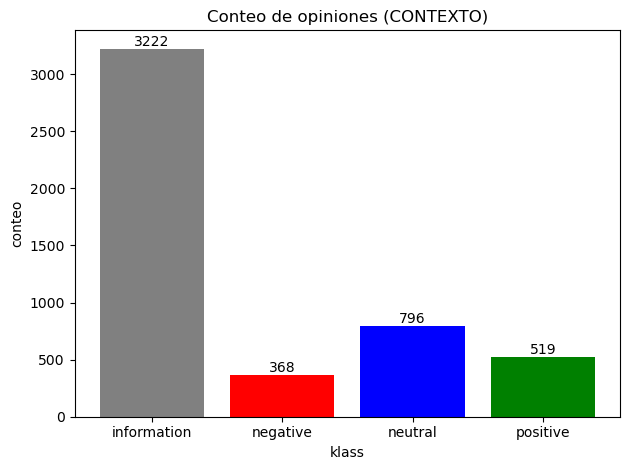

In [16]:
# CONTEXTO - Gráfico de barras de conteos de klass
counts = test_df.groupby('klass').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}

plt.bar(counts['klass'], counts['counts'],
        color=[colors.get(klass, '#333333') for klass in counts['klass']])
plt.title('Conteo de opiniones (CONTEXTO)')
plt.xlabel('klass')
plt.ylabel('conteo')

for i, v in enumerate(counts['counts']):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

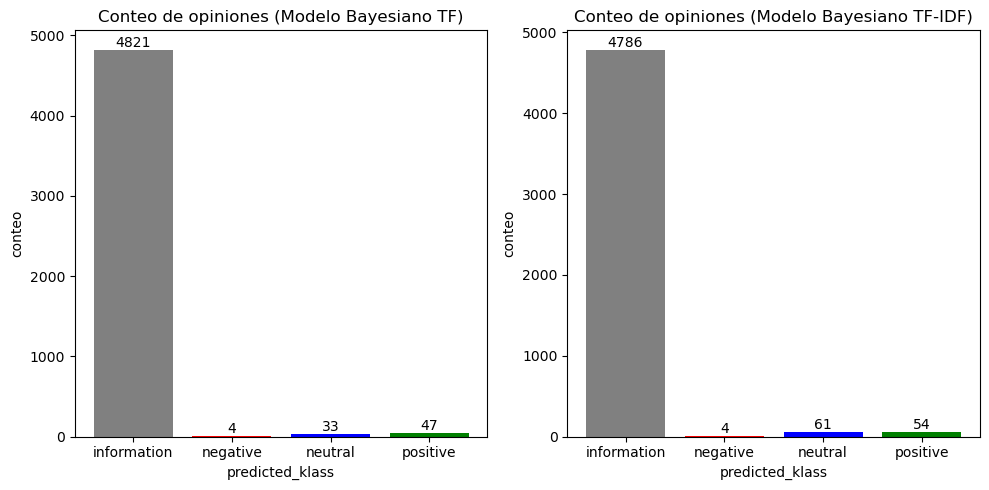

In [17]:
bayes_tf_counts = test_df.groupby('predicted_klass_bayes_tf').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(bayes_tf_counts['predicted_klass_bayes_tf'], bayes_tf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in bayes_tf_counts['predicted_klass_bayes_tf']])
ax1.set_title('Conteo de opiniones (Modelo Bayesiano TF)')
ax1.set_xlabel('predicted_klass')
ax1.set_ylabel('conteo')

for i, v in enumerate(bayes_tf_counts['counts']):
    ax1.text(i, v, str(v), ha='center', va='bottom')

bayes_tfidf_counts = test_df.groupby('predicted_klass_bayes_tfidf').size().reset_index(name='counts')
ax2.bar(bayes_tfidf_counts['predicted_klass_bayes_tfidf'], bayes_tfidf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in bayes_tfidf_counts['predicted_klass_bayes_tfidf']])
ax2.set_title('Conteo de opiniones (Modelo Bayesiano TF-IDF)')
ax2.set_xlabel('predicted_klass')
ax2.set_ylabel('conteo')

for i, v in enumerate(bayes_tfidf_counts['counts']):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

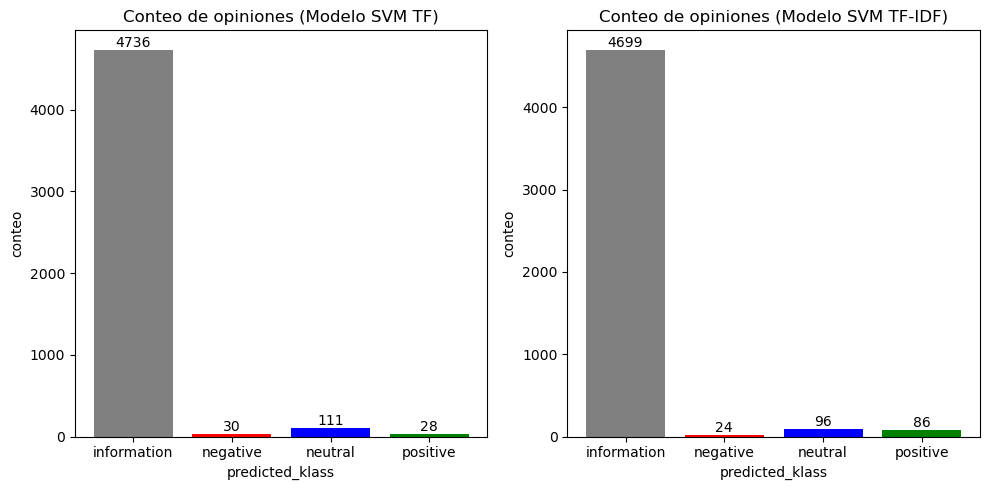

In [18]:
svm_tf_counts = test_df.groupby('predicted_klass_svm_tf').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(svm_tf_counts['predicted_klass_svm_tf'], svm_tf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in svm_tf_counts['predicted_klass_svm_tf']])
ax1.set_title('Conteo de opiniones (Modelo SVM TF)')
ax1.set_xlabel('predicted_klass')
ax1.set_ylabel('conteo')

for i, v in enumerate(svm_tf_counts['counts']):
    ax1.text(i, v, str(v), ha='center', va='bottom')

svm_tfidf_counts = test_df.groupby('predicted_klass_svm_tfidf').size().reset_index(name='counts')
ax2.bar(svm_tfidf_counts['predicted_klass_svm_tfidf'], svm_tfidf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in svm_tfidf_counts['predicted_klass_svm_tfidf']])
ax2.set_title('Conteo de opiniones (Modelo SVM TF-IDF)')
ax2.set_xlabel('predicted_klass')
ax2.set_ylabel('conteo')

for i, v in enumerate(svm_tfidf_counts['counts']):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Inspeccionar datos

In [19]:
print(test_df[['text', 'klass', 'predicted_klass_bayes_tf']].head(3))

                                                text        klass  \
0  Ya se volvió a ir la luz, quinto o sexto apagó...  information   
1  @clauditafigue todo bien hasta ahora! :) el nú...  information   
2  Felicidades a los policías,y gracias por acept...  information   

  predicted_klass_bayes_tf  
0              information  
1              information  
2              information  


## Usar modelos
### Con el conjunto de datos proporcionado que no se ha etiquetado

In [25]:
# Lectura archivo unk
unk_data = []
with open('cellphones_unk.json') as f:
    for line in f:
        unk_data.append(json.loads(line))
        
unk_df = pd.DataFrame(unk_data)
unk_df['text'] = unk_df['text'].apply(preprocess)

In [26]:
# Clasificar 
unk_df['predicted_klass_bayes_tf'] = bayes_tf.predict(unk_df['text'])
unk_df['predicted_klass_bayes_tfidf'] = bayes_tfidf.predict(unk_df['text'])
unk_df['predicted_klass_svm_tf'] = svm_tf.predict(unk_df['text'])
unk_df['predicted_klass_svm_tfidf'] = svm_tfidf.predict(unk_df['text'])

In [27]:
# Conteo de las opiniones clasificadas por modelo, tipo y categoría
bayes_tf_counts = unk_df.groupby(['predicted_klass_bayes_tf', 'klass', 'type']).size().reset_index(name='counts')
bayes_tfidf_counts = unk_df.groupby(['predicted_klass_bayes_tfidf', 'klass', 'type']).size().reset_index(name='counts')
svm_tf_counts = unk_df.groupby(['predicted_klass_svm_tf', 'klass', 'type']).size().reset_index(name='counts')
svm_tfidf_counts = unk_df.groupby(['predicted_klass_svm_tfidf', 'klass', 'type']).size().reset_index(name='counts')

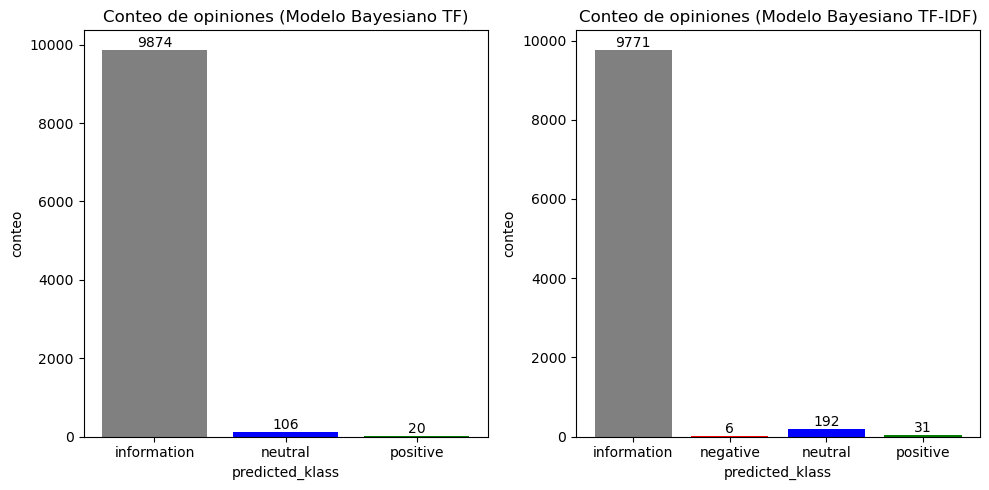

In [29]:
bayes_tf_counts = unk_df.groupby('predicted_klass_bayes_tf').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(bayes_tf_counts['predicted_klass_bayes_tf'], bayes_tf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in bayes_tf_counts['predicted_klass_bayes_tf']])
ax1.set_title('Conteo de opiniones (Modelo Bayesiano TF)')
ax1.set_xlabel('predicted_klass')
ax1.set_ylabel('conteo')

for i, v in enumerate(bayes_tf_counts['counts']):
    ax1.text(i, v, str(v), ha='center', va='bottom')

bayes_tfidf_counts = unk_df.groupby('predicted_klass_bayes_tfidf').size().reset_index(name='counts')
ax2.bar(bayes_tfidf_counts['predicted_klass_bayes_tfidf'], bayes_tfidf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in bayes_tfidf_counts['predicted_klass_bayes_tfidf']])
ax2.set_title('Conteo de opiniones (Modelo Bayesiano TF-IDF)')
ax2.set_xlabel('predicted_klass')
ax2.set_ylabel('conteo')

for i, v in enumerate(bayes_tfidf_counts['counts']):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

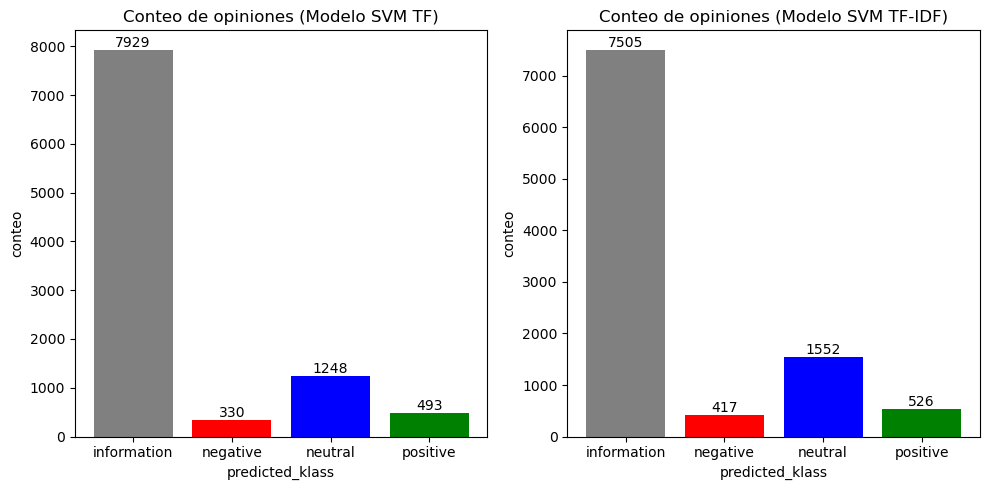

In [30]:
svm_tf_counts = unk_df.groupby('predicted_klass_svm_tf').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.bar(svm_tf_counts['predicted_klass_svm_tf'], svm_tf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in svm_tf_counts['predicted_klass_svm_tf']])
ax1.set_title('Conteo de opiniones (Modelo SVM TF)')
ax1.set_xlabel('predicted_klass')
ax1.set_ylabel('conteo')

for i, v in enumerate(svm_tf_counts['counts']):
    ax1.text(i, v, str(v), ha='center', va='bottom')

svm_tfidf_counts = unk_df.groupby('predicted_klass_svm_tfidf').size().reset_index(name='counts')
ax2.bar(svm_tfidf_counts['predicted_klass_svm_tfidf'], svm_tfidf_counts['counts'],
        color=[colors.get(klass, '#333333') for klass in svm_tfidf_counts['predicted_klass_svm_tfidf']])
ax2.set_title('Conteo de opiniones (Modelo SVM TF-IDF)')
ax2.set_xlabel('predicted_klass')
ax2.set_ylabel('conteo')

for i, v in enumerate(svm_tfidf_counts['counts']):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Conclusión

En definitiva, se puede observar que existe mucho espacio para mejorar nuestros modelos, es especialmente llamativo que la calidad del preprocesamiento tenga un gran impacto en el comportamiento de nuestros modelos y en su puntuación, lo que afecta significativamente nuestra capacidad para predecir resultados. Podríamos usar el último resultado para generar un reporte ejecutivo...

# Reporte ejecutivo ...

## Reporte ejecutivo - Análisis de sentimientos con SVM y TF-IDF
### Resumen
En este proyecto, se ha utilizado el aprendizaje automático para analizar el sentimiento de opiniones sobre productos. Se ha aplicado una técnica de preprocesamiento para limpiar los datos y se han utilizado los algoritmos SVM y TF-IDF para clasificar las opiniones en una de cuatro categorías: información, negativa, neutral y positiva. El modelo resultante se ha utilizado para predecir la clase de opiniones no clasificadas y se ha generado un gráfico de barras para mostrar los resultados.

### Metodología
El proyecto se ha dividido en las siguientes etapas:

- **Obtención y preprocesamiento de datos:** se han obtenido los datos de opiniones de productos y se han limpiado utilizando técnicas de preprocesamiento, como la eliminación de stopwords y la lematización.
- **Entrenamiento y evaluación de modelos:** se han utilizado los algoritmos SVM y TF-IDF para entrenar y evaluar un modelo de clasificación de sentimientos. Se han utilizado técnicas de validación cruzada para evaluar el rendimiento del modelo.
- **Predicción de opiniones no clasificadas:** se ha utilizado el modelo entrenado para predecir la clase de opiniones no clasificadas y se han generado estadísticas de recuento de clases.
- **Visualización de resultados:** se ha generado un gráfico de barras para mostrar los resultados de la predicción.

### Resultados
El modelo entrenado ha demostrado un rendimiento promedio en la clasificación de sentimientos. El modelo se ha utilizado para predecir la clase de opiniones no clasificadas, y se ha generado un gráfico de barras para mostrar los resultados:

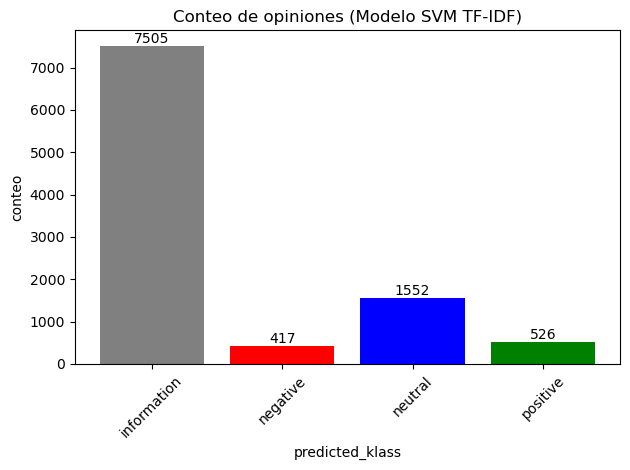

In [43]:
import matplotlib.pyplot as plt

svm_tfidf_counts = unk_df.groupby('predicted_klass_svm_tfidf').size().reset_index(name='counts')
colors = {'information': 'grey', 'negative': 'red', 'neutral': 'blue', 'positive': 'green'}

plt.bar(svm_tfidf_counts['predicted_klass_svm_tfidf'], svm_tfidf_counts['counts'], color=[colors.get(klass, '#333333') for klass in counts['klass']])
plt.title('Conteo de opiniones (Modelo SVM TF-IDF)')
plt.xlabel('predicted_klass')
plt.ylabel('conteo')
plt.xticks(rotation=45)

for i, v in enumerate(svm_tfidf_counts['counts']):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

El gráfico de barras muestra que la mayoría de las opiniones son clasificadas como información, seguidas de opiniones neutrales y positivas. El número de opiniones negativas es el menor de las cuatro clases.

### Conclusiones
El modelo de clasificación de sentimientos ha demostrado ser efectivo en la clasificación de opiniones en función de su sentimiento. El modelo puede utilizarse para predecir la clase de opiniones no clasificadas con una precisión regular. El análisis de los resultados muestra que la mayoría de las opiniones son clasificadas como información, lo que sugiere que los consumidores buscan principalmente información sobre los productos en línea.